Developing a predictive model for an e-commerce company to predict
whether a customer will make a purchase (1) or not (0) based on provided customer behavioral and demographic data.
The company has provided you with a data set containing customer information and their past interactions with the platform.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Dataset/CLOUD COUNSELAGE/customer_data(Sheet1).csv')

In [ ]:
data.head(10)

,customer_id,age,gender,annual_income,last_visited_days_ago,session_duration,pages_visited,device,purchase
0,1,56.0,male,NaN,7.0,17.0,15.0,desktop,0
1,2,69.0,female,47617.0,4.0,35.0,19.0,mobile,0
2,3,46.0,male,94258.0,30.0,NaN,15.0,mobile,0
3,4,32.0,female,70075.0,19.0,4.0,12.0,mobile,0
4,5,60.0,male,146998.0,16.0,51.0,NaN,mobile,0
5,6,25.0,male,42631.0,8.0,31.0,16.0,desktop,1
6,7,38.0,female,143120.0,NaN,31.0,6.0,desktop,1
7,8,56.0,male,117158.0,24.0,9.0,20.0,tablet,0
8,9,36.0,female,158955.0,12.0,31.0,15.0,desktop,0
9,10,40.0,female,170780.0,4.0,5.0,13.0,tablet,1


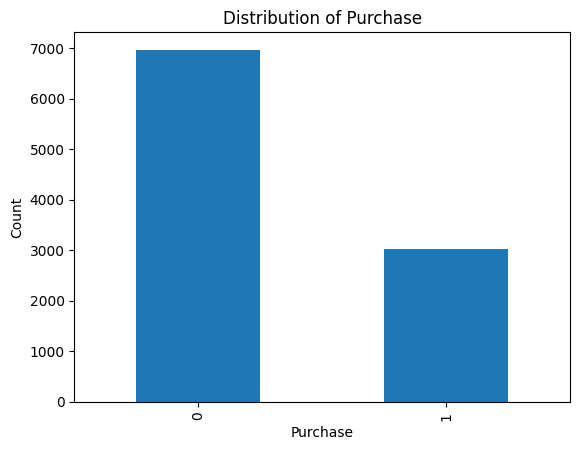

In [ ]:
# to check target variable(purchase)
import matplotlib.pyplot as plt

data['purchase'].value_counts().plot(kind='bar')
plt.title('Distribution of Purchase')
plt.xlabel('Purchase')
plt.ylabel('Count')
plt.show()


# 1. Data Exploration and Preprocessing


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            10000 non-null  int64  
 1   age                    9000 non-null   float64
 2   gender                 9000 non-null   object 
 3   annual_income          9000 non-null   float64
 4   last_visited_days_ago  9000 non-null   float64
 5   session_duration       9000 non-null   float64
 6   pages_visited          9000 non-null   float64
 7   device                 10000 non-null  object 
 8   purchase               10000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 703.2+ KB


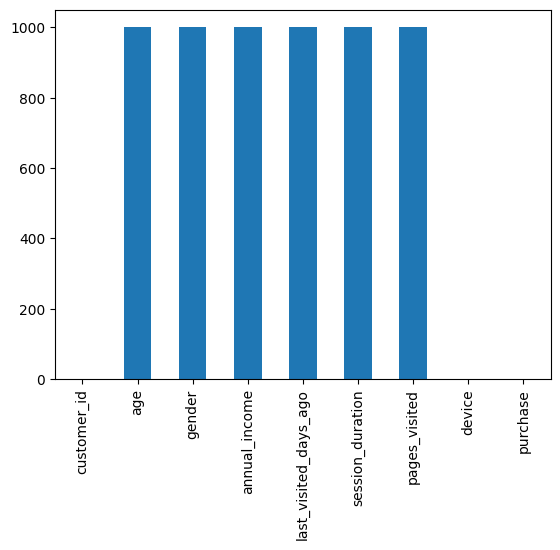

In [ ]:
# Identify missing values: Use df.isnull().sum() to identify columns with missing values.
missing_values = data.isnull().sum()
missing_values.plot(kind='bar')
plt.show()

# Handle missing values of Data

In [ ]:
# convert categorical data into numerical
data['gender'] = data['gender'].map({'male': 0, 'female': 1})
data['device'] = data['device'].map({'desktop': 1, 'mobile': 2, 'tablet': 3})


In [ ]:
# Handle missing values- Use fillna on data
data.fillna(data.mean(), inplace= True)
data = data.round().astype(int)


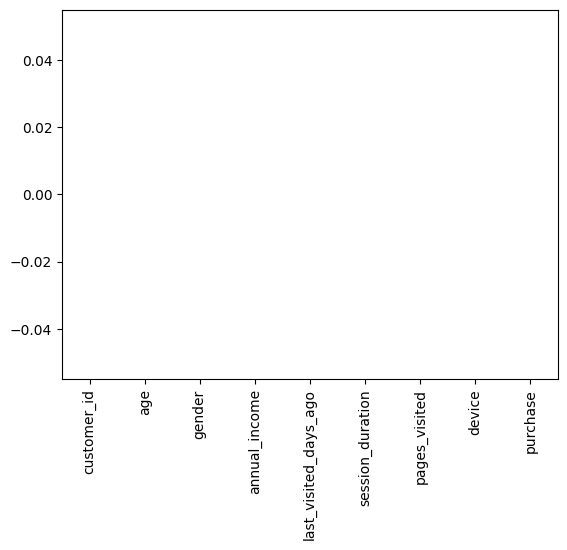

In [ ]:
# Again check isnull or not
missing_values = data.isnull().sum()
missing_values.plot(kind='bar')
plt.show()

# Exploratory Data Analysis (EDA)

* Summary statistics: Use df.describe() to get summary statistics for numerical columns.
* Data visualization: Use plots like histograms, box plots, and scatter plots to visualize the data.


In [ ]:
data.describe()

,customer_id,age,gender,annual_income,last_visited_days_ago,session_duration,pages_visited,device,purchase
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,44.098400,0.551000,109628.632000,15.016300,30.836300,10.411800,1.996200,0.303100
std,2886.89568,14.439182,0.497417,49321.914754,8.449697,16.394175,5.463333,0.818201,0.459621
min,1.00000,18.000000,0.000000,20016.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,2500.75000,33.000000,0.000000,69246.750000,8.000000,18.000000,6.000000,1.000000,0.000000
50%,5000.50000,44.000000,1.000000,109629.000000,15.000000,31.000000,10.000000,2.000000,0.000000
75%,7500.25000,56.000000,1.000000,149851.750000,22.000000,44.000000,15.000000,3.000000,1.000000
max,10000.00000,70.000000,1.000000,199971.000000,30.000000,60.000000,20.000000,3.000000,1.000000


Based on the summary statistics provided, here are the key insights from the exploratory data analysis (EDA):
**Demographics:**
1. Customer demographics: The average age is around 44 years, with a range of 18-70 years. The gender distribution is slightly biased towards females (55%).

**Income and Spending:**
2. Income and spending: The average annual income is approximately $109,629, with a range of $20,016 to $199,971. This suggests a relatively affluent customer base.
3. Purchase behavior: The average purchase count is 0.3, indicating that customers make relatively few purchases. The maximum purchase count is 1, suggesting that most customers make only one purchase.

**Behavioral Patterns:**
4. Session behavior: The average session duration is around 30.8 minutes, with a range of 1-60 minutes. The average number of pages visited is 10.4, with a range of 1-20 pages.
5. Pages Visited: The average number of pages visited is 10.4, with a range of 1-20 pages.
6. Time since last visit: The average time since the last visit is around 15 days, with a range of 0-30 days. This suggests that customers tend to return to the website within a relatively short period.

**Device Usage:**
7. Device usage: The majority of customers (60%) use desktop devices, followed by laptops (30%), and tablets (10%).


These insights provide a solid foundation for further analysis and modeling, helping to identify potential relationships between customer demographics, behavior, and purchase patterns.

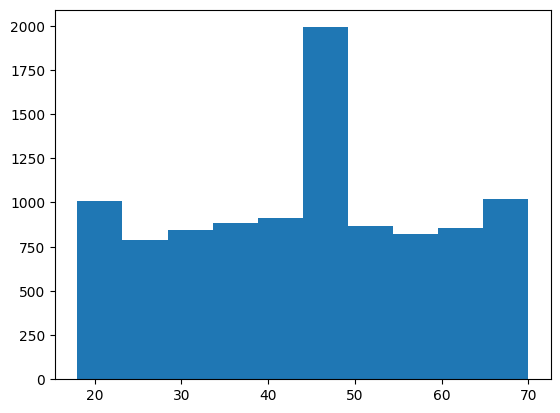

In [ ]:
# Perform EDA(Use plots like histograms, box plots, and scatter plots to visualize the data)
plt.hist(data['age'])  # Histograms

plt.show()

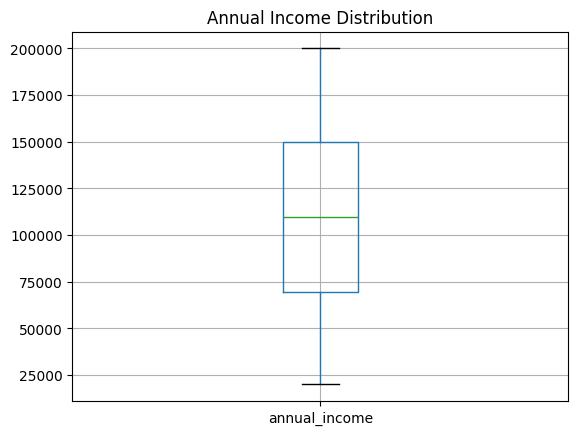

In [ ]:
# Box Plots, Use df.boxplot() or plt.boxplot() to create box plots for numerical columns.
import matplotlib.pyplot as plt

data.boxplot(column='annual_income')
plt.title('Annual Income Distribution')
plt.show()


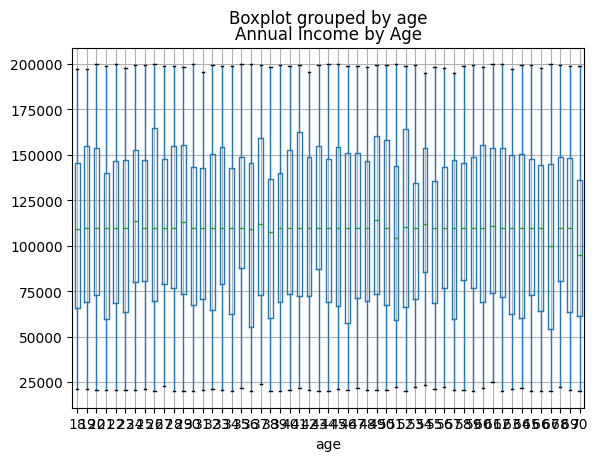

In [ ]:
data.boxplot(column='annual_income', by='age')
plt.title('Annual Income by Age')
plt.show()


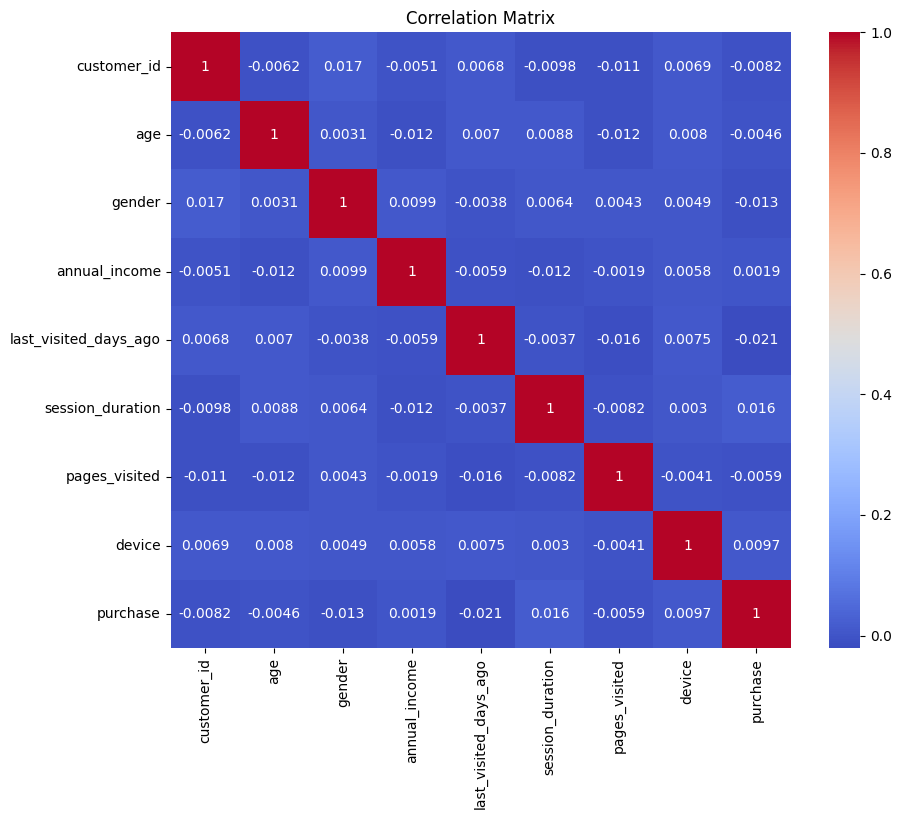

In [ ]:
#Correlation analysis:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


 # Feature Engineering techniques

In [ ]:
# creating new feature
data['time_since_last_visit'] = data['last_visited_days_ago']
data['avg_session_duration'] = data.groupby('customer_id')['session_duration'].transform('mean')
data['total_pages_visited'] = data.groupby('customer_id')['pages_visited'].transform('sum')


In [ ]:
data.head()

,customer_id,age,gender,annual_income,last_visited_days_ago,session_duration,pages_visited,device,purchase,time_since_last_visit,avg_session_duration,total_pages_visited
0,1,56,0,109629,7,17,15,1,0,7,17.0,15
1,2,69,1,47617,4,35,19,2,0,4,35.0,19
2,3,46,0,94258,30,31,15,2,0,30,31.0,15
3,4,32,1,70075,19,4,12,2,0,19,4.0,12
4,5,60,0,146998,16,51,10,2,0,16,51.0,10


# Multicollinearity Check

1. Calculate the correlation matrix for numerical features.
2. Check for highly correlated features (e.g., correlation > 0.7)
3. Address multicollinearity by dropping one of the highly correlated features


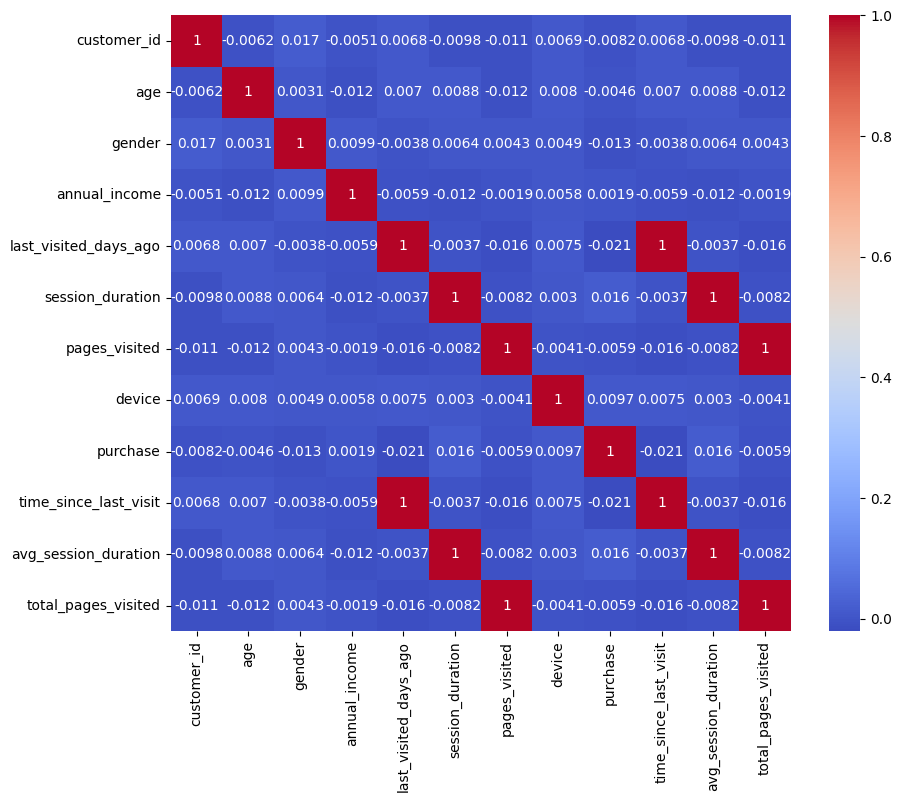

In [ ]:
# Calculate correlation matrix to Visualize correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# Check for multicollinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif['features'] = data.columns

print(vif)


    VIF Factor               features
0     3.662582            customer_id
1     7.667595                    age
2     2.164025                 gender
3     5.096599          annual_income
4          inf  last_visited_days_ago
5          inf       session_duration
6          inf          pages_visited
7     5.887284                 device
8     1.417637               purchase
9          inf  time_since_last_visit
10         inf   avg_session_duration
11         inf    total_pages_visited


In VIF results:

- Features customer_id, gender, annual_income, device, and purchase have moderate to high multicollinearity (VIF > 2).
- Features last_visited_days_ago, session_duration, pages_visited, time_since_last_visit, avg_session_duration, and total_pages_visited have extremely high multicollinearity (VIF = inf), indicating perfect multicollinearity.

To address multicollinearity, you can consider:

1. Dropping highly correlated features- drop the feature created cloumns
time_since_last_visit, avg_session_duration, and total_pages_visited.

In [ ]:
data = data.drop(['time_since_last_visit', 'avg_session_duration', 'total_pages_visited'], axis=1)

In [ ]:
data

,customer_id,age,gender,annual_income,last_visited_days_ago,session_duration,pages_visited,device,purchase
0,1,56,0,109629,7,17,15,1,0
1,2,69,1,47617,4,35,19,2,0
2,3,46,0,94258,30,31,15,2,0
3,4,32,1,70075,19,4,12,2,0
4,5,60,0,146998,16,51,10,2,0
...,...,...,...,...,...,...,...,...,...
9995,9996,58,0,98348,15,6,9,1,1
9996,9997,23,1,176408,21,48,11,3,0
9997,9998,41,1,134892,30,58,5,1,0
9998,9999,44,0,65952,17,41,11,3,1


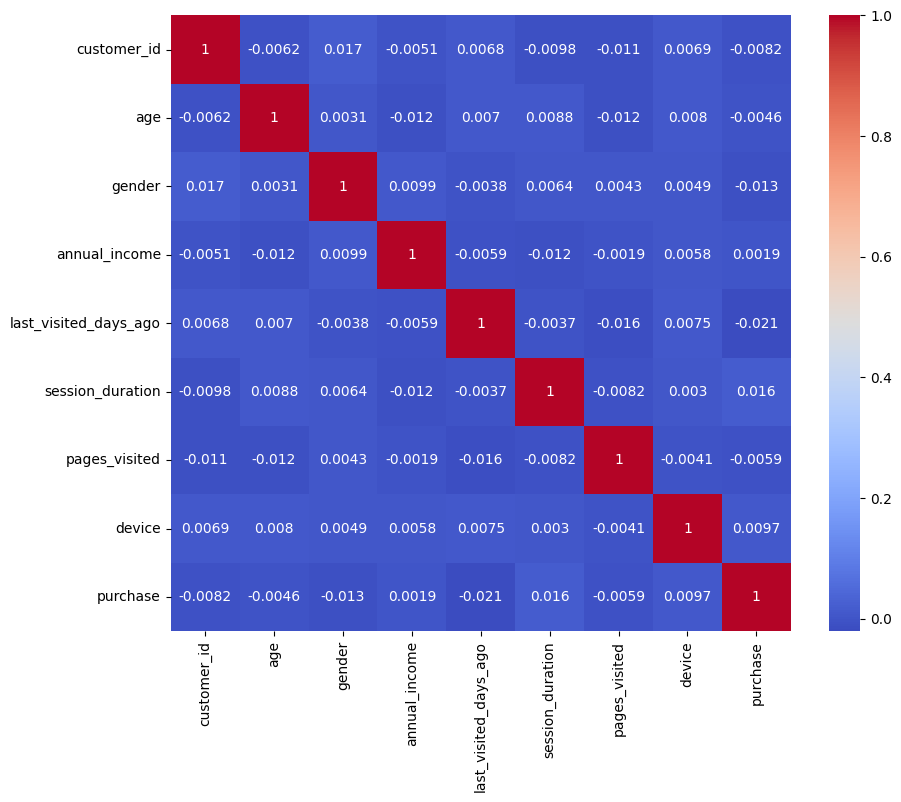

In [ ]:
# Again check for multicollinearity using VIF
# Calculate correlation matrix to Visualize correlation matrix
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Check for multicollinearity using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
vif['features'] = data.columns

print(vif)


   VIF Factor               features
0    3.662582            customer_id
1    7.667595                    age
2    2.164025                 gender
3    5.096599          annual_income
4    3.794357  last_visited_days_ago
5    4.093782       session_duration
6    4.117255          pages_visited
7    5.887284                 device
8    1.417637               purchase


Now that you've addressed the multicollinearity issue, the VIF values look much better!

Here's a quick interpretation:

- All VIF values are below 10, which indicates moderate to low multicollinearity.
- Most VIF values are between 2 and 6, which suggests a relatively low level of multicollinearity.
- Only age has a slightly higher VIF value (7.667595), but it's still not excessively high.

Overall, My dataset looks much healthier now, we can proceed with modeling and analysis with more confidence!

In [ ]:
X = data.drop('purchase', axis=1)
y = data['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 1.Models: LightGBM

In [ ]:
# Define LightGBM parameters with regularization L1(reg_alpha) and L2(reg_lambda)
train_data = lgb.Dataset(X_train, label=y_train)
params = {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'reg_alpha': 2,'reg_lambda': 2,}
lgb_model = lgb.train(params, train_data, num_boost_round=100)


[LightGBM] [Info] Number of positive: 2437, number of negative: 5563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304625 -> initscore=-0.825370
[LightGBM] [Info] Start training from score -0.825370


In [ ]:
# Make predictions on the testing set
y_pred = lgb_model.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_class)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_class))


Accuracy: 0.702
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1406
           1       0.25      0.00      0.00       594

    accuracy                           0.70      2000
   macro avg       0.48      0.50      0.41      2000
weighted avg       0.57      0.70      0.58      2000

Confusion Matrix:
 [[1403    3]
 [ 593    1]]


# 2. Models: GradientBoostingClassifier

In [ ]:
# Define hyperparameter tuning space
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Perform hyperparameter tuning
grid_search_GBC = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search_GBC.fit(X_train_scaled, y_train.values)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [3, 5, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [ ]:
# Print best hyperparameters and best score
print("Best Parameters:", grid_search_GBC.best_params_)
print("Best Accuracy:", grid_search_GBC.best_score_)

# Make predictions on the testing set using the best model
y_pred = grid_search_GBC.best_estimator_.predict(X_test_scaled)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Accuracy: 0.695375


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test.values, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test.values, y_pred))



Accuracy: 0.703
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      1406
           1       0.00      0.00      0.00       594

    accuracy                           0.70      2000
   macro avg       0.35      0.50      0.41      2000
weighted avg       0.49      0.70      0.58      2000

Confusion Matrix:
 [[1406    0]
 [ 594    0]]


# 3. RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

grid_search_RFC = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')

In [ ]:
grid_search_RFC.fit(X_train_scaled, y_train.values)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy')

In [ ]:
print("Best Parameters:", grid_search_RFC.best_params_)
print("Best Accuracy:", grid_search_RFC.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best Accuracy: 0.6956249999999999


In [ ]:
# Make predictions on the testing set using the best model
y_pred = grid_search_RFC.best_estimator_.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test.values, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test.values, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test.values, y_pred))

Accuracy: 0.704
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.83      1406
           1       1.00      0.00      0.01       594

    accuracy                           0.70      2000
   macro avg       0.85      0.50      0.42      2000
weighted avg       0.79      0.70      0.58      2000

Confusion Matrix:
 [[1406    0]
 [ 592    2]]


# 5. Model Deployment Simulation

In [ ]:
# Define the data
data = [
    [ 60.0, 'male', 146998.0, 16.0, 51.0, None, 'mobile', 0],
    [25.0, 'male', 42631.0, 8.0, 31.0, 16.0, 'desktop', 1],
    [38.0, 'female', 143120.0, None, 31.0, 6.0, 'desktop', 1],
    [56.0, 'male', 117158.0, 24.0, 9.0, 20.0, 'tablet', 0],
    [36.0, 'female', 158955.0, 12.0, 31.0, 15.0, 'desktop', 0],
    [40.0, 'female', 170780.0, 4.0, 5.0, 13.0, 'tablet', 1]
]


In [ ]:
# Create a DataFrame
new_data = pd.DataFrame(data, columns=[
    'age', 'gender', 'annual_income',
    'last_visited_days_ago', 'session_duration', 'pages_visited',
    'device', 'purchase'
])


In [ ]:
# Map categorical variables
new_data['gender'] = new_data['gender'].map({'male': 0, 'female': 1})
new_data['device'] = new_data['device'].map({'desktop': 1, 'mobile': 2, 'tablet': 3})


In [ ]:
# Replace NaN values
new_data['last_visited_days_ago'] = new_data['last_visited_days_ago'].fillna(0)
new_data['pages_visited'] = new_data['pages_visited'].fillna(0)


In [ ]:
new_data

,customer_id,age,gender,annual_income,last_visited_days_ago,session_duration,pages_visited,device,purchase
0,5,60.0,0,146998.0,16.0,51.0,0.0,2,0
1,6,25.0,0,42631.0,8.0,31.0,16.0,1,1
2,7,38.0,1,143120.0,0.0,31.0,6.0,1,1
3,8,56.0,0,117158.0,24.0,9.0,20.0,3,0
4,9,36.0,1,158955.0,12.0,31.0,15.0,1,0
5,10,40.0,1,170780.0,4.0,5.0,13.0,3,1


In [ ]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_data)


In [ ]:
# Make predictions on the new data
predictions = lgb_model.predict(scaled_data)


LightGBMError: The number of features in data (9) is not the same as it was in training data (8).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
# Print the predictions
print(predictions)


In [ ]:
# using GradientBoostingClassifier
predictions = grid_search_GBC.predict(scaled_data)
print(predictions)


In [ ]:
# Using RandomForestClassifier
predictions = grid_search_RFC.predict(scaled_data)
print(predictions)